# Denoising Diffusion Probabilistic Model

Kernel Author: Minsu Kang

Email: mskang1478@gmail.com

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 100

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [6]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y
    
model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims, 
                 diffusion_time_embedding_dim=timestep_embedding_dim, 
                 n_times=n_timesteps).to(DEVICE)

### Define Gaussian Diffusion

In [7]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):
    
        super(Diffusion, self).__init__()
    
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model
        
        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        scale = 1000/n_times
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)
                                     
        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)
        
        self.device = device
    
    def extract(self, a, t, x_shape):
        """
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
    
    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1
    
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5
    
    def make_noisy(self, x_zeros, t): 
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)
        
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)
        
        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar
    
        return noisy_sample.detach(), epsilon
    
    
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)
        
        B, _, _, _ = x_zeros.shape
        
        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)
        
        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)
        
        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)
        
        return perturbed_images, epsilon, pred_epsilon
    
    
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)
        
        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)
        
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)
        
        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        
        return x_t_minus_1.clamp(-1., 1)
                
    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)
        
        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)
        
        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)
        
        return x_0
    
    
diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps, 
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### Visualizing forward process

In [9]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [10]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

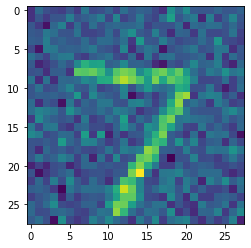

In [11]:
show_image(perturbed_images, idx=0)

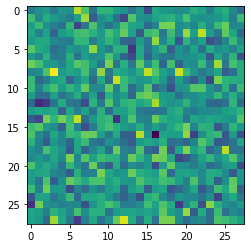

In [12]:
show_image(perturbed_images, idx=1)

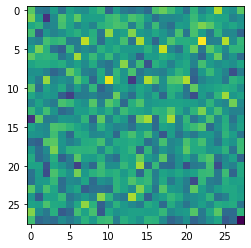

In [13]:
show_image(perturbed_images, idx=2)

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

In [14]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)
        
        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)
        
        noise_prediction_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)
    
print("Finish!!")

Start training DDPMs...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:56<00:00,  8.37it/s]

	Epoch 1 complete! 	Denoising Loss:  0.09228709118010905



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:56<00:00,  8.26it/s]

	Epoch 2 complete! 	Denoising Loss:  0.03921726712574943



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:56<00:00,  8.24it/s]

	Epoch 3 complete! 	Denoising Loss:  0.03503601436511192



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.17it/s]

	Epoch 4 complete! 	Denoising Loss:  0.0331084030186837



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.16it/s]

	Epoch 5 complete! 	Denoising Loss:  0.0316347570803303



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.15it/s]

	Epoch 6 complete! 	Denoising Loss:  0.030466001910658982



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.15it/s]

	Epoch 7 complete! 	Denoising Loss:  0.02958814895703879



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 8 complete! 	Denoising Loss:  0.02894801299812065



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.13it/s]

	Epoch 9 complete! 	Denoising Loss:  0.02875868263694211



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 10 complete! 	Denoising Loss:  0.02830209654286249



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 11 complete! 	Denoising Loss:  0.02778377826524596



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 12 complete! 	Denoising Loss:  0.027353518093243625



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 13 complete! 	Denoising Loss:  0.027072675076400876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 14 complete! 	Denoising Loss:  0.026943923527390785



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 15 complete! 	Denoising Loss:  0.026867163566569995



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 16 complete! 	Denoising Loss:  0.026664981021521948



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.13it/s]

	Epoch 17 complete! 	Denoising Loss:  0.02639550434696114



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 18 complete! 	Denoising Loss:  0.026195885330979895



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 19 complete! 	Denoising Loss:  0.02611028557866175



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 20 complete! 	Denoising Loss:  0.025730368466331408



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.14it/s]

	Epoch 21 complete! 	Denoising Loss:  0.025604173759969637



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 22 complete! 	Denoising Loss:  0.025634787077259306



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 23 complete! 	Denoising Loss:  0.025526717086282805



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.13it/s]

	Epoch 24 complete! 	Denoising Loss:  0.02533433507554806



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 25 complete! 	Denoising Loss:  0.02516592551086448



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 26 complete! 	Denoising Loss:  0.025191107088238254



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 27 complete! 	Denoising Loss:  0.02536129852772778



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 28 complete! 	Denoising Loss:  0.02487828667697489



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 29 complete! 	Denoising Loss:  0.024973911953628317



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 30 complete! 	Denoising Loss:  0.02487563222853674



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 31 complete! 	Denoising Loss:  0.02471427218670137



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 32 complete! 	Denoising Loss:  0.024760971132379312



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 33 complete! 	Denoising Loss:  0.02450728853050078



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 34 complete! 	Denoising Loss:  0.024548637006097496



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 35 complete! 	Denoising Loss:  0.024277604053704403



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 36 complete! 	Denoising Loss:  0.024141727620337762



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 37 complete! 	Denoising Loss:  0.02433031123991196



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 38 complete! 	Denoising Loss:  0.02429502446634265



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 39 complete! 	Denoising Loss:  0.023901055296325784



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.12it/s]

	Epoch 40 complete! 	Denoising Loss:  0.024187417410345923



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 41 complete! 	Denoising Loss:  0.02401205334159681



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 42 complete! 	Denoising Loss:  0.02395051881336631



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:03<00:00,  7.39it/s]

	Epoch 43 complete! 	Denoising Loss:  0.024153460728593618



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 44 complete! 	Denoising Loss:  0.023689733133611515



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 45 complete! 	Denoising Loss:  0.023675235032111917



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 46 complete! 	Denoising Loss:  0.0239440736750889



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 47 complete! 	Denoising Loss:  0.023873817494027633



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 48 complete! 	Denoising Loss:  0.023633941781157866



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 49 complete! 	Denoising Loss:  0.023635422783052057



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 50 complete! 	Denoising Loss:  0.023775912658112425



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 51 complete! 	Denoising Loss:  0.023649227228334062



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 52 complete! 	Denoising Loss:  0.023601070161845185



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 53 complete! 	Denoising Loss:  0.023645843387159526



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 54 complete! 	Denoising Loss:  0.02361295059418831



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 55 complete! 	Denoising Loss:  0.02344835963116115



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 56 complete! 	Denoising Loss:  0.023391585920451798



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 57 complete! 	Denoising Loss:  0.023152732099287022



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 58 complete! 	Denoising Loss:  0.023514594779246382



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 59 complete! 	Denoising Loss:  0.023359612402561892



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 60 complete! 	Denoising Loss:  0.023183548460818



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 61 complete! 	Denoising Loss:  0.023340353947212428



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 62 complete! 	Denoising Loss:  0.02334859441074296



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 63 complete! 	Denoising Loss:  0.023164363148120735



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 64 complete! 	Denoising Loss:  0.02334316640606739



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.11it/s]

	Epoch 65 complete! 	Denoising Loss:  0.023284648931147452



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 66 complete! 	Denoising Loss:  0.02309552455543835



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 67 complete! 	Denoising Loss:  0.02302049080299962



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 68 complete! 	Denoising Loss:  0.023131220410458554



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 69 complete! 	Denoising Loss:  0.02304429409460316



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 70 complete! 	Denoising Loss:  0.023198872736981537



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 71 complete! 	Denoising Loss:  0.02261032692443293



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 72 complete! 	Denoising Loss:  0.023112870995592102



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 73 complete! 	Denoising Loss:  0.02285849561707841



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 74 complete! 	Denoising Loss:  0.02295990641682576



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 75 complete! 	Denoising Loss:  0.02281089285468189



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 76 complete! 	Denoising Loss:  0.023001913596183445



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 77 complete! 	Denoising Loss:  0.02268747126476632



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 78 complete! 	Denoising Loss:  0.022718371909000296



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 79 complete! 	Denoising Loss:  0.022844849643894494



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 80 complete! 	Denoising Loss:  0.02279600179475597



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.05it/s]

	Epoch 81 complete! 	Denoising Loss:  0.022938969964957517



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 82 complete! 	Denoising Loss:  0.02289685782474967



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 83 complete! 	Denoising Loss:  0.02267474329704021



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 84 complete! 	Denoising Loss:  0.022476297528602373



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 85 complete! 	Denoising Loss:  0.02277262496929138



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.05it/s]

	Epoch 86 complete! 	Denoising Loss:  0.02243951781708588



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 87 complete! 	Denoising Loss:  0.022727339120549906



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 88 complete! 	Denoising Loss:  0.02268622075724933



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.05it/s]

	Epoch 89 complete! 	Denoising Loss:  0.02265416096466092



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.06it/s]

	Epoch 90 complete! 	Denoising Loss:  0.022688917859465394



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 91 complete! 	Denoising Loss:  0.02247497679777125



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 92 complete! 	Denoising Loss:  0.022642928374628734



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 93 complete! 	Denoising Loss:  0.022325781016793642



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 94 complete! 	Denoising Loss:  0.022659293582869902



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.10it/s]

	Epoch 95 complete! 	Denoising Loss:  0.022725331023908578



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.08it/s]

	Epoch 96 complete! 	Denoising Loss:  0.02241694477872334



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 97 complete! 	Denoising Loss:  0.022497776770391144



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:57<00:00,  8.09it/s]

	Epoch 98 complete! 	Denoising Loss:  0.02240205218251317



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 99 complete! 	Denoising Loss:  0.022444008101319145



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:58<00:00,  8.07it/s]

	Epoch 100 complete! 	Denoising Loss:  0.02217927309644655
Finish!!


## Step 4. Sample images from noise.

In [15]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

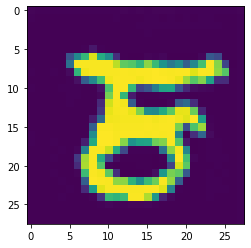

In [16]:
show_image(generated_images, idx=0)

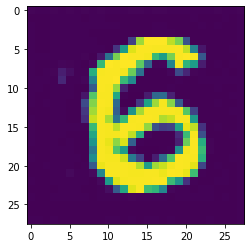

In [17]:
show_image(generated_images, idx=1)

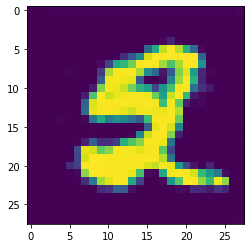

In [18]:
show_image(generated_images, idx=2)

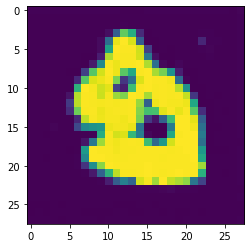

In [19]:
show_image(generated_images, idx=3)

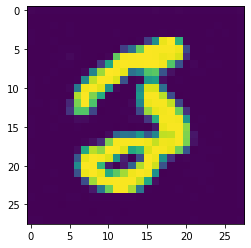

In [20]:
show_image(generated_images, idx=4)

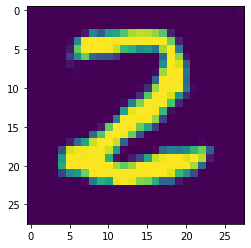

In [21]:
show_image(generated_images, idx=5)

### Comparison with ground-truth samples

In [22]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

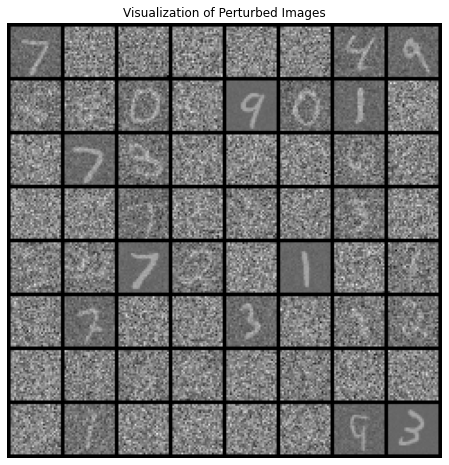

In [24]:
draw_sample_image(perturbed_images, "Perturbed Images")

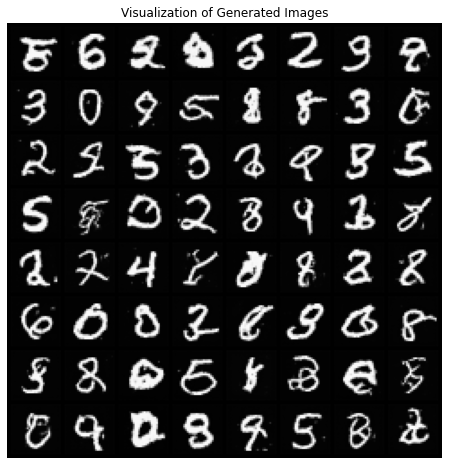

In [23]:
draw_sample_image(generated_images, "Generated Images")

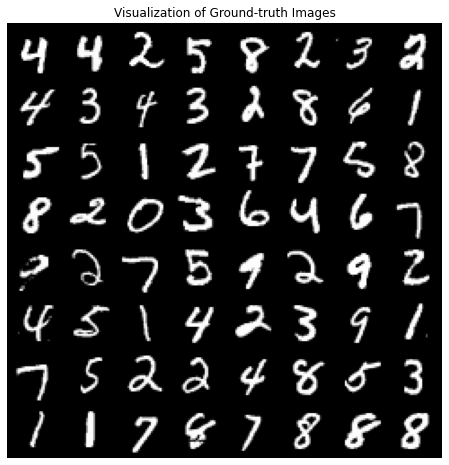

In [25]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")